In [21]:
import math
import copy
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from IPython.display import clear_output, display
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller, kpss
from scipy import fft, signal
sns.set(style="darkgrid")
%config IPCompleter.greedy = True
%config Completer.use_jedi = False
sns.mpl.rc('figure',figsize=(20, 6))

In [22]:
%run 8.1-forecasting-methods.ipynb

In [23]:
data_load_second_interval = 5
minute_interval = 1
min_peak_size = 5000

In [24]:
resample_second_interval = 60*15

In [25]:
resample_minutes = resample_second_interval / 60

In [26]:
hour_observations = int(60/resample_minutes)
half_hour_observations = int(hour_observations/2)
day_observations = int(60/resample_second_interval*60*24)
three_day_observations = int(60/resample_second_interval*60*24*3)
week_observations = int(60/resample_second_interval*60*24*7)

#### Load data

In [64]:
data = pd.read_csv(f"../../data/corrected_m2/corrected_data_2_{minute_interval}m_{data_load_second_interval}s.csv")
data['ndt'] = pd.to_datetime(data['ndt'])

In [65]:
peaks = pd.read_csv(f"../../data/peaks/peaks.csv")

In [66]:
sea = pd.read_csv(f"../../data/seasonal.csv")

In [67]:
sea_data = data[data['hash'].isin(sea['hash'])].groupby('ndt').sum()

In [68]:
sea_data = sea_data.resample(f'{resample_second_interval}S').sum()

In [69]:
forecast_minutes = 180

In [70]:
forecast_observations = 3 * hour_observations

#### Forecast anomaly free data

In [165]:
anomaly_free_data = sea_data.copy()

In [166]:
pd.options.mode.chained_assignment = None 

def mean_range(data, start, end):
    past_start = pd.Timestamp(start) - pd.Timedelta(days=1)
    past_end = pd.Timestamp(end) - pd.Timedelta(days=1)
    future_start = pd.Timestamp(start) + pd.Timedelta(days=1)
    future_end = pd.Timestamp(end) + pd.Timedelta(days=1)
    new_vals = data.loc[past_start:past_end]['count'].values + data.loc[future_start:future_end]['count'].values / 2
    data.loc[start:end]['count'] = new_vals
    return data

In [167]:
anomaly_free_data = mean_range(anomaly_free_data, '2019-07-22 12:30:00','2019-07-22 12:45:00')
anomaly_free_data = mean_range(anomaly_free_data, '2019-07-22 08:00:00','2019-07-22 08:00:00')
anomaly_free_data = mean_range(anomaly_free_data, '2019-07-22 13:45:00','2019-07-22 13:45:00')
anomaly_free_data = mean_range(anomaly_free_data, '2019-07-24 13:00:00','2019-07-24 13:00:00')
anomaly_free_data = mean_range(anomaly_free_data, '2019-07-29 12:15:00','2019-07-29 12:45:00')
anomaly_free_data = mean_range(anomaly_free_data, '2019-08-01 13:00:00','2019-08-01 14:15:00')
anomaly_free_data = mean_range(anomaly_free_data, '2019-08-02 14:15:00','2019-08-02 14:45:00')

In [ ]:
anomaly_free_data['2019-07-20 08:45:00':].plot()

# Components #

In [11]:
stl = STL(sea_data, period=int(day_observations), seasonal=7)
res = stl.fit()

[]

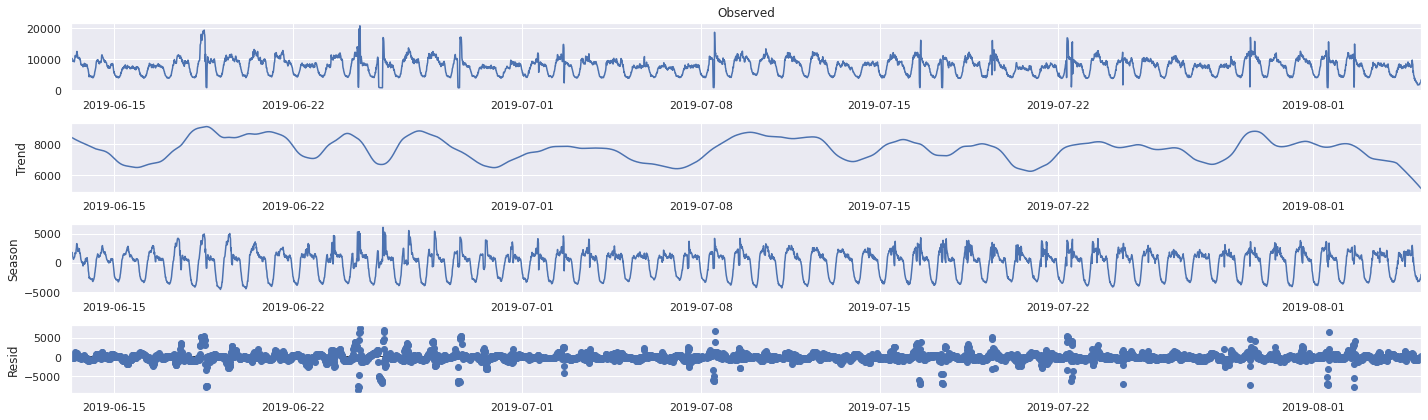

In [12]:
#fig = plt.figure(figsize=(20,20))
res.plot()
plt.plot()

# Stationarity and differencing #

In [13]:
sea_data_diff = sea_data.diff().dropna() 
sea_data_sdiff = sea_data_diff.diff().dropna()
sea_data_sea_diff = sea_data.diff(day_observations).dropna()
sea_data_sea_diff_diff = sea_data_sea_diff.diff().dropna()

## Unmodified data ##

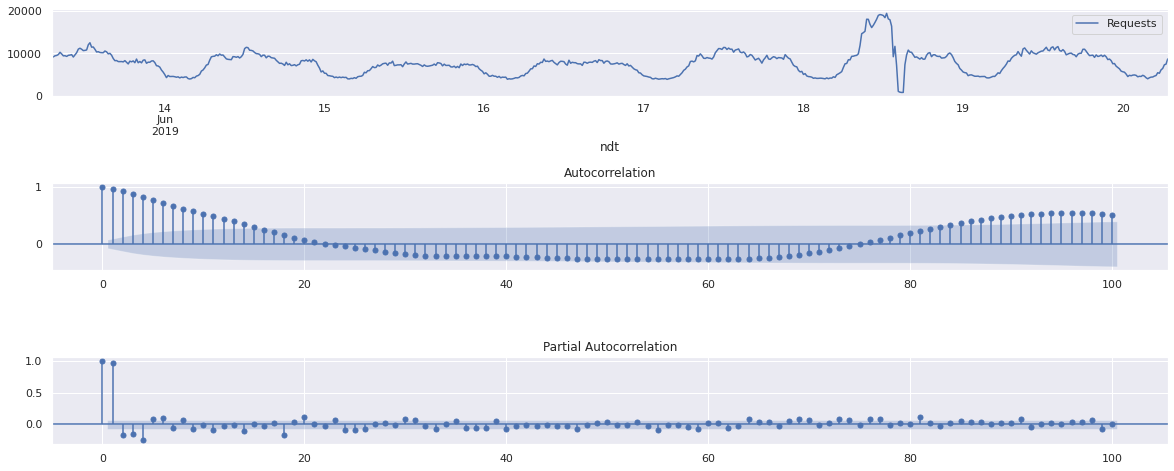

In [14]:
plot_data_stationarity(sea_data[:week_observations])

In [15]:
kpss_test(sea_data)

Results of KPSS Test:
Test Statistic            0.091464
p-value                   0.100000
Lags Used                40.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/home/jakub/.conda/envs/bp_thesis_pyr/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1886: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


Fail to reject null the hypothesis (data is stationary).

In [16]:
adf_test(sea_data)

Results of Dickey-Fuller Test:
Test Statistic                -1.366873e+01
p-value                        1.473564e-25
#Lags Used                     2.900000e+01
Number of Observations Used    5.054000e+03
Critical Value (1%)           -3.431645e+00
Critical Value (5%)           -2.862112e+00
Critical Value (10%)          -2.567075e+00
dtype: float64


* https://otexts.com/fpp2/stationarity.html#unit-root-tests

## First difference ##

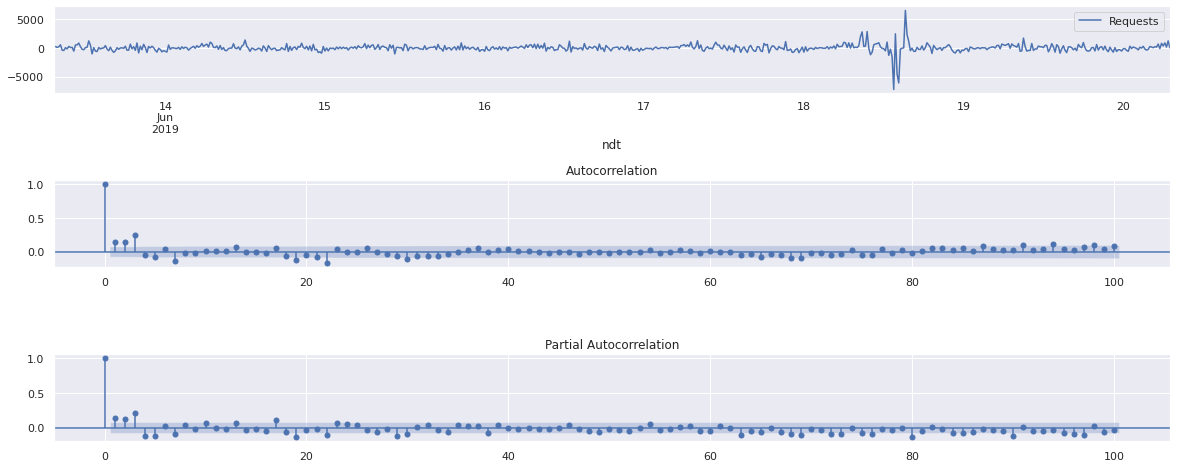

In [17]:
plot_data_stationarity(sea_data_diff[:week_observations])

In [18]:
kpss_test(sea_data_diff)

Results of KPSS Test:
Test Statistic            0.005363
p-value                   0.100000
Lags Used                42.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/home/jakub/.conda/envs/bp_thesis_pyr/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1886: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


In [19]:
adf_test(sea_data_diff)

Results of Dickey-Fuller Test:
Test Statistic                -1.550677e+01
p-value                        2.376836e-28
#Lags Used                     3.300000e+01
Number of Observations Used    5.049000e+03
Critical Value (1%)           -3.431646e+00
Critical Value (5%)           -2.862113e+00
Critical Value (10%)          -2.567075e+00
dtype: float64


## Second difference ##

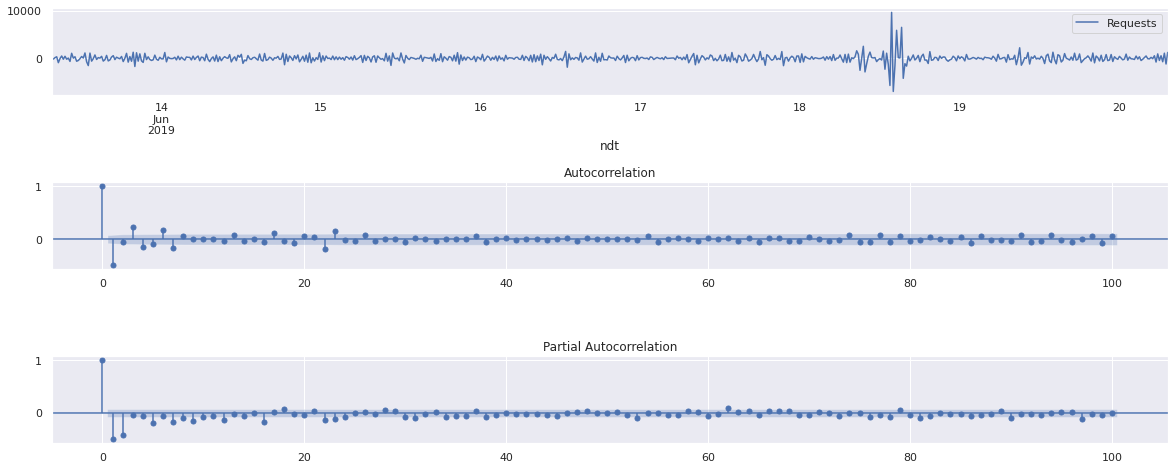

In [20]:
plot_data_stationarity(sea_data_sdiff[:week_observations])

In [21]:
kpss_test(sea_data_sdiff)

Results of KPSS Test:
Test Statistic             0.020036
p-value                    0.100000
Lags Used                202.000000
Critical Value (10%)       0.347000
Critical Value (5%)        0.463000
Critical Value (2.5%)      0.574000
Critical Value (1%)        0.739000
dtype: float64


/home/jakub/.conda/envs/bp_thesis_pyr/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1886: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


In [22]:
adf_test(sea_data_sdiff)

Results of Dickey-Fuller Test:
Test Statistic                  -20.156455
p-value                           0.000000
#Lags Used                       33.000000
Number of Observations Used    5048.000000
Critical Value (1%)              -3.431646
Critical Value (5%)              -2.862113
Critical Value (10%)             -2.567075
dtype: float64


## Seasonal difference ##

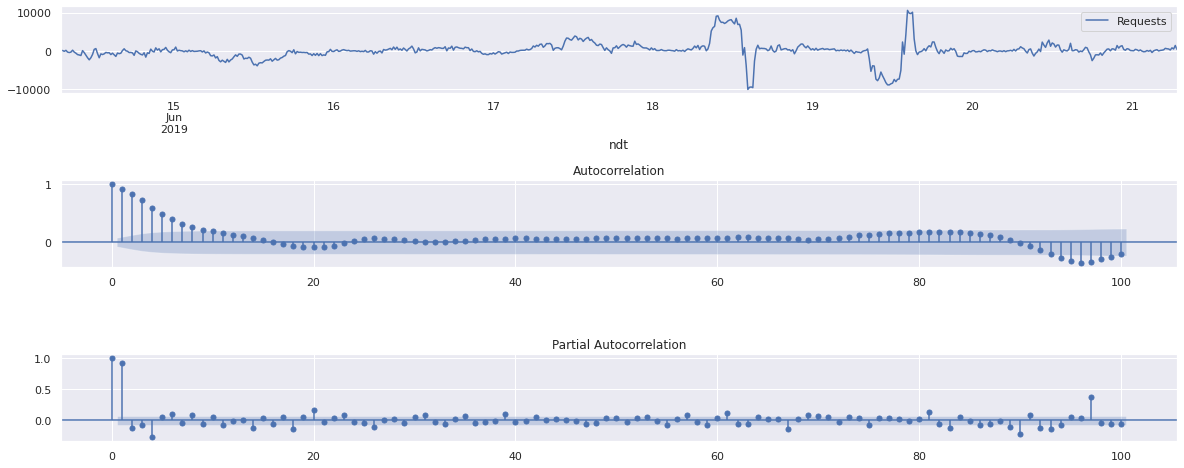

In [23]:
plot_data_stationarity(sea_data_sea_diff[:week_observations])

In [24]:
kpss_test(sea_data_sea_diff)

Results of KPSS Test:
Test Statistic            0.046358
p-value                   0.100000
Lags Used                35.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/home/jakub/.conda/envs/bp_thesis_pyr/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1886: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


In [25]:
adf_test(sea_data_sea_diff)

Results of Dickey-Fuller Test:
Test Statistic                -9.678858e+00
p-value                        1.219875e-16
#Lags Used                     2.400000e+01
Number of Observations Used    4.963000e+03
Critical Value (1%)           -3.431668e+00
Critical Value (5%)           -2.862123e+00
Critical Value (10%)          -2.567080e+00
dtype: float64


# Forecasting #

## Test and training split ##

In [42]:
timespan_start = data['ndt'].min()
training_timestamp = pd.date_range(start=timespan_start, end='2019-07-20 08:42:00', freq=f'{resample_second_interval}S')
training_split = len(sea_data.loc[:training_timestamp[-1]]) #int(len(sea_data)*0.7) # 70%

In [43]:
training_split

3559

In [44]:
sea_data.index[0]

Timestamp('2019-06-13 07:00:00', freq='900S')

In [45]:
sea_data.index[-1]

Timestamp('2019-08-05 05:45:00', freq='900S')

In [46]:
sea_data.index[training_split] 

Timestamp('2019-07-20 08:45:00', freq='900S')

In [47]:
sea_data.index[training_split] - sea_data.index[0]

Timedelta('37 days 01:45:00')

## Naive Method

In [36]:
naive_mod = naive_method(sea_data[:training_split])

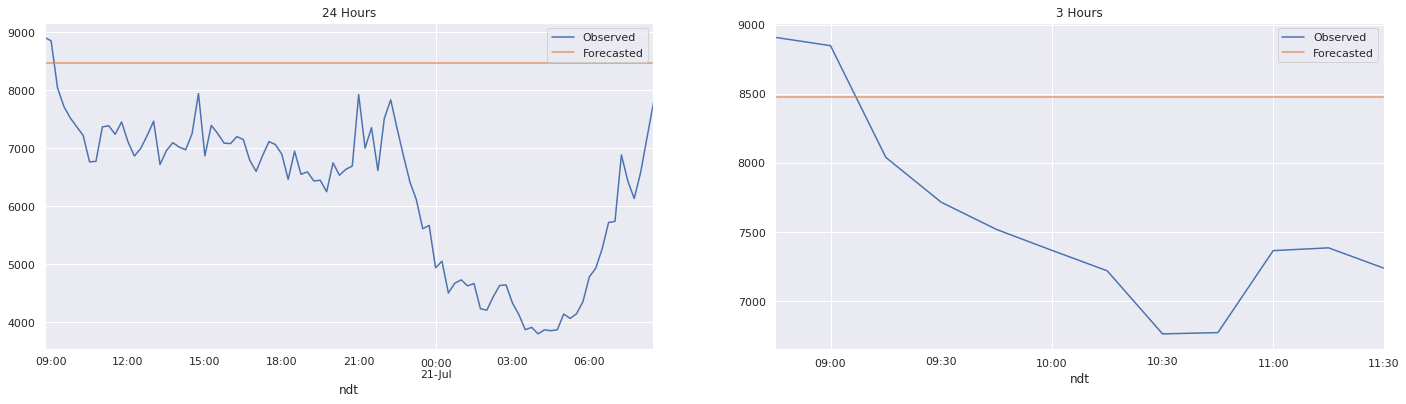

In [25]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(24, 6)
ax[0].set_title("24 Hours")
ax[1].set_title("3 Hours")
showcase_zoom(sea_data[training_split:training_split+day_observations], pd.Series(naive_mod.forecast(day_observations)), ax[0])
showcase_zoom(sea_data[training_split:training_split+forecast_observations], pd.Series(naive_mod.forecast(forecast_observations)), ax[1])

In [30]:
naive_mod_forecasts = forecast_n_steps(sea_data, naive_mod, training_split, forecast_observations, end=training_split+day_observations)

Text(0.5, 1.0, '"Live" - 180 Minutes ahead forecasts as new observations are added.')

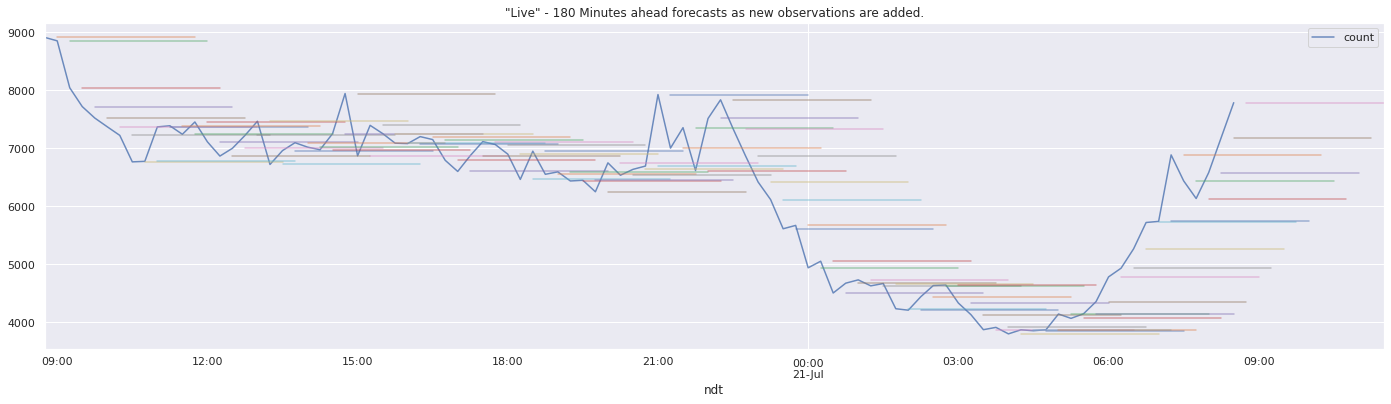

In [43]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(24, 6)
sea_data[training_split:training_split+day_observations].plot(ax=ax, alpha=0.8)

for forecast in naive_mod_forecasts[1].iterrows():
    pd.Series(forecast[1].values,
              index = pd.date_range(
                  start=forecast[0] + pd.Timedelta(minutes=resample_minutes),
                  end=forecast[0] + pd.Timedelta(minutes=forecast_minutes),
                  freq=f"{resample_second_interval}S")
             ).plot(ax=ax, alpha=0.5)

ax.set_title("\"Live\" - 180 Minutes ahead forecasts as new observations are added.")

In [37]:
_, naive_errors = error_n_steps(sea_data, naive_mod, training_split, forecast_observations)

## Average method

In [44]:
average_method_mod = average_method(sea_data[:training_split], forecast_observations)

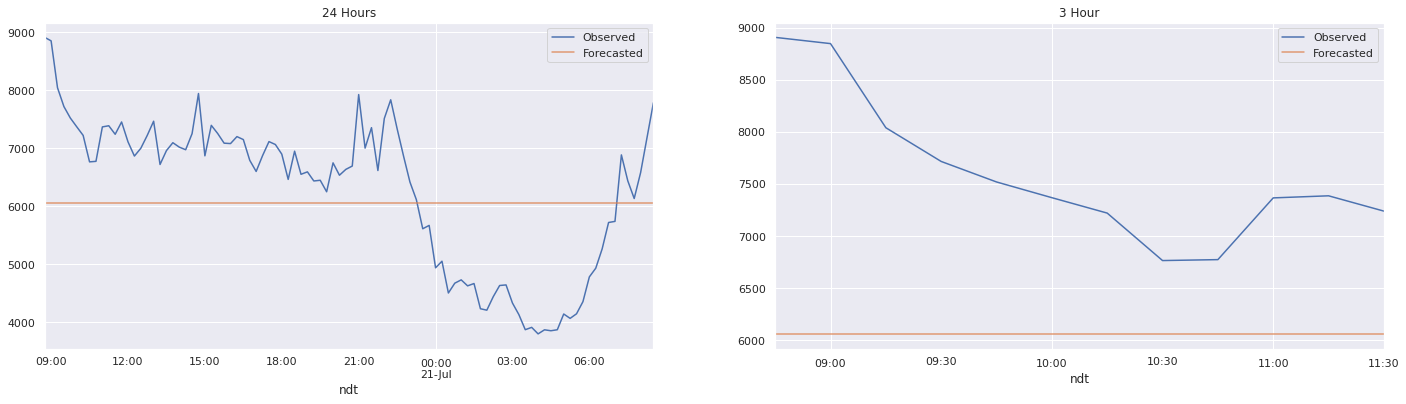

In [39]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(24, 6)
ax[0].set_title("24 Hours")
ax[1].set_title("3 Hour")
showcase_zoom(sea_data[training_split:training_split+day_observations], pd.Series(average_method_mod.forecast(day_observations)), ax[0])
showcase_zoom(sea_data[training_split:training_split+forecast_observations], pd.Series(average_method_mod.forecast(forecast_observations)), ax[1])

In [41]:
average_method_forecasts = forecast_n_steps(sea_data, average_method_mod, training_split, forecast_observations, end=training_split+day_observations)

Text(0.5, 1.0, '"Live" - 180 Minutes ahead forecasts as new observations are added.')

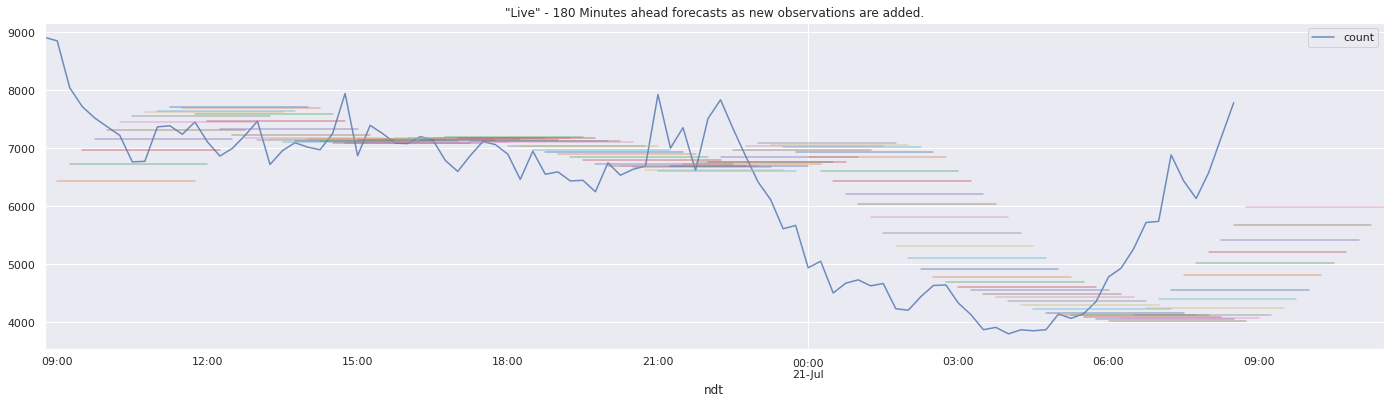

In [42]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(24, 6)
sea_data[training_split:training_split+day_observations].plot(ax=ax, alpha=0.8)

for forecast in average_method_forecasts[1].iterrows():
    pd.Series(forecast[1].values,
              index = pd.date_range(
                  start=forecast[0] + pd.Timedelta(minutes=resample_minutes),
                  end=forecast[0] + pd.Timedelta(minutes=forecast_minutes),
                  freq=f"{resample_second_interval}S")
             ).plot(ax=ax, alpha=0.5)

ax.set_title("\"Live\" - 180 Minutes ahead forecasts as new observations are added.")

In [45]:
_, average_errors = error_n_steps(sea_data, average_method_mod, training_split, forecast_observations)

## Seasonal Naive Method (24-hour)

In [53]:
seasonal_naive_mod = seasonal_naive_method(sea_data[:training_split], day_observations)

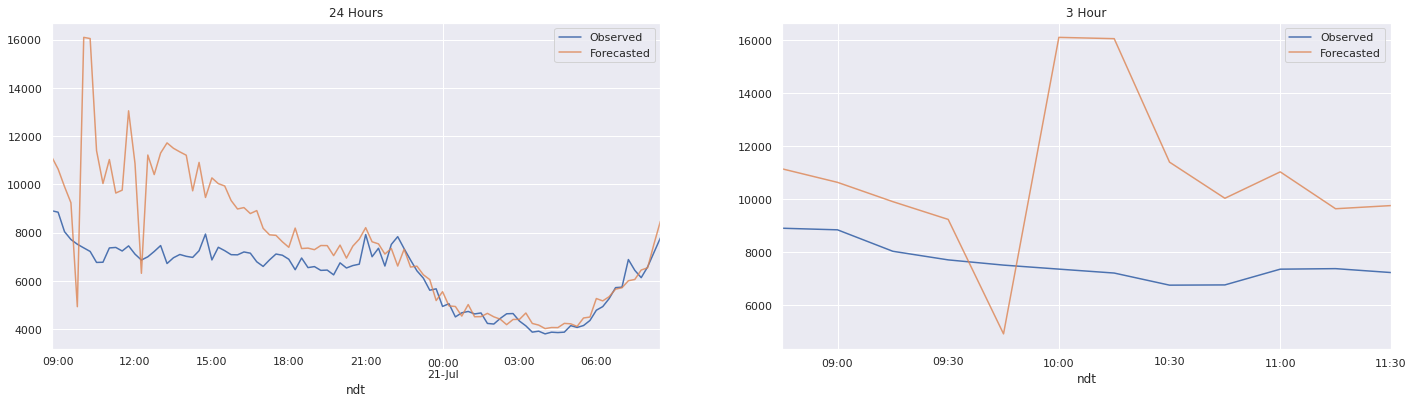

In [47]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(24, 6)
ax[0].set_title("24 Hours")
ax[1].set_title("3 Hour")
showcase_zoom(sea_data[training_split:training_split+day_observations], pd.Series(seasonal_naive_mod.forecast(day_observations)), ax[0])
showcase_zoom(sea_data[training_split:training_split+forecast_observations], pd.Series(seasonal_naive_mod.forecast(forecast_observations)), ax[1])

In [48]:
seasonal_naive_forecasts = forecast_n_steps(sea_data, seasonal_naive_mod, training_split, forecast_observations, end=training_split+day_observations)

Text(0.5, 1.0, '"Live" - 60 Minutes ahead forecasts as new observations are added.')

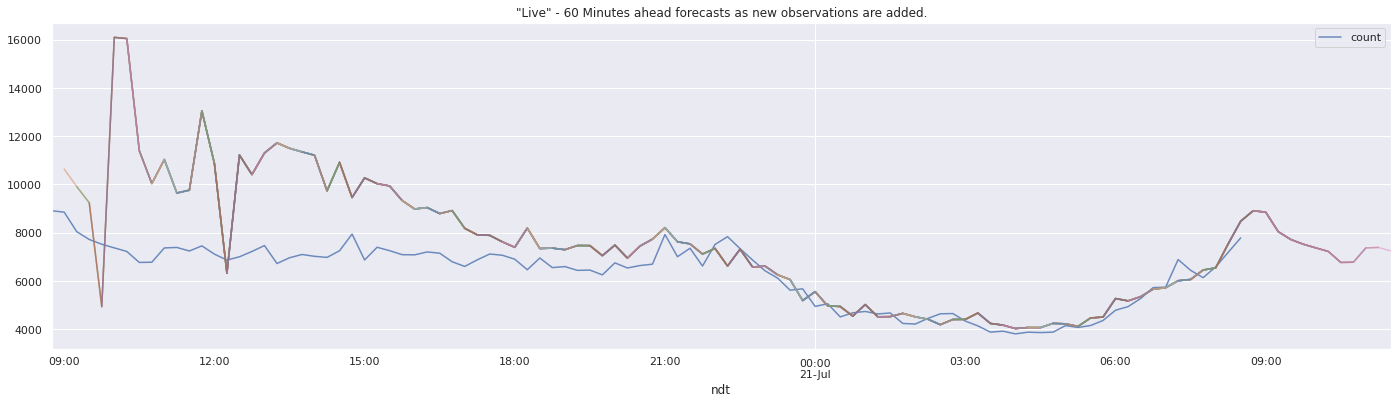

In [50]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(24, 6)
sea_data[training_split:training_split+day_observations].plot(ax=ax, alpha=0.8)

for forecast in seasonal_naive_forecasts[1].iterrows():
    pd.Series(forecast[1].values,
              index = pd.date_range(
                  start=forecast[0] + pd.Timedelta(minutes=resample_minutes),
                  end=forecast[0] + pd.Timedelta(minutes=forecast_minutes),
                  freq=f"{resample_second_interval}S")
             ).plot(ax=ax, alpha=0.5)

ax.set_title("\"Live\" - 180 Minutes ahead forecasts as new observations are added.")

In [54]:
_, seasonal_naive_errors = error_n_steps(sea_data, seasonal_naive_mod, training_split, forecast_observations)

## AR(1)

In [ ]:
#https://www.statsmodels.org/dev/examples/notebooks/generated/autoregressions.html

In [59]:
ar_1_mod = sm.tsa.SARIMAX(sea_data[:training_split], order=(1,0,0), trend='c')
ar_1_res = ar_1_mod.fit()

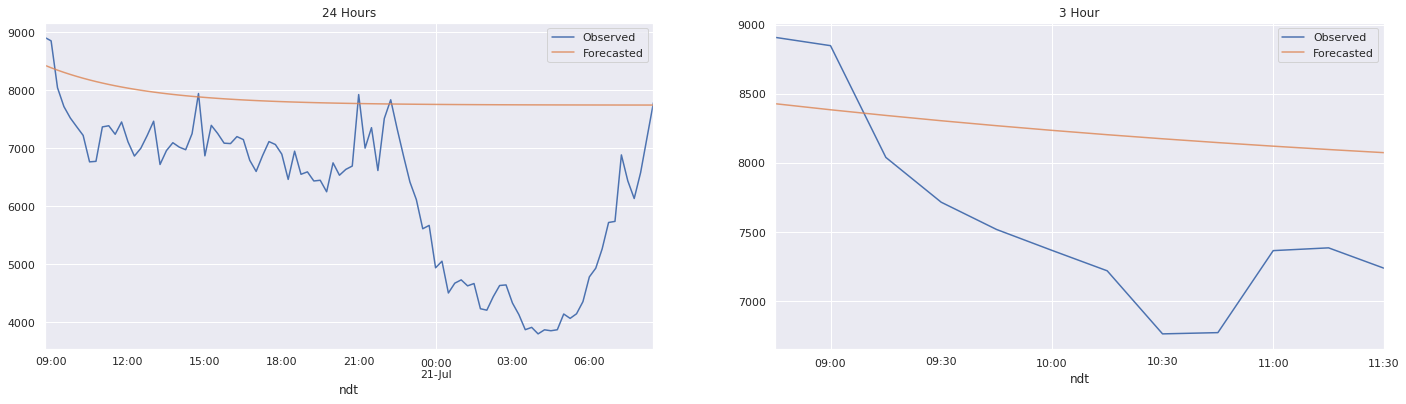

In [56]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(24, 6)
ax[0].set_title("24 Hours")
ax[1].set_title("3 Hour")
showcase_zoom(sea_data[training_split:training_split+day_observations], pd.Series(ar_1_res.forecast(day_observations)), ax[0])
showcase_zoom(sea_data[training_split:training_split+forecast_observations], pd.Series(ar_1_res.forecast(forecast_observations)), ax[1])

In [57]:
ar_1_forecasts = forecast_n_steps(sea_data, ar_1_res, training_split, forecast_observations, end=training_split+day_observations)

Text(0.5, 1.0, '"Live" - 180 Minutes ahead forecasts as new observations are added.')

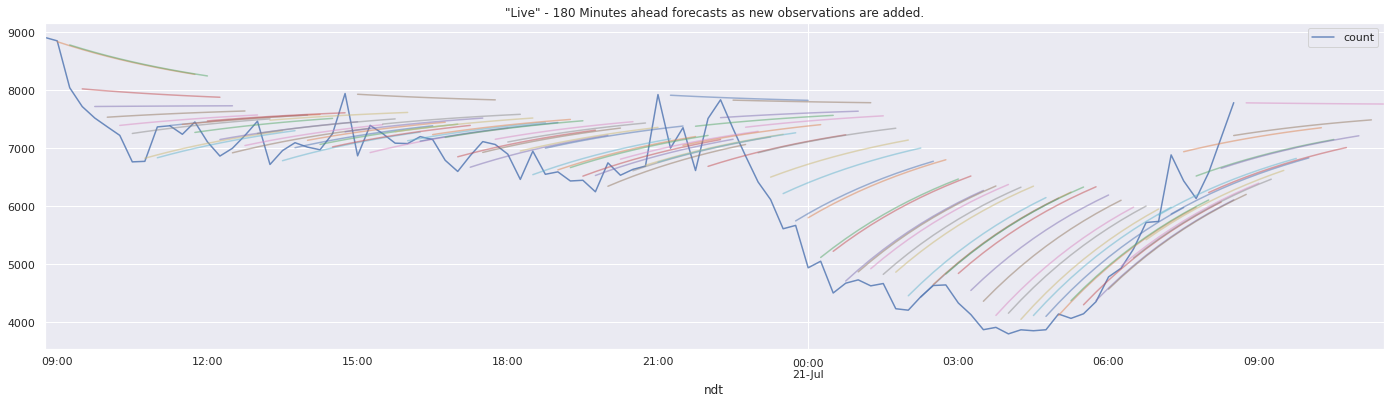

In [58]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(24, 6)
sea_data[training_split:training_split+day_observations].plot(ax=ax, alpha=0.8)

for forecast in ar_1_forecasts[1].iterrows():
    pd.Series(forecast[1].values,
              index = pd.date_range(
                  start=forecast[0] + pd.Timedelta(minutes=resample_minutes),
                  end=forecast[0] + pd.Timedelta(minutes=forecast_minutes),
                  freq=f"{resample_second_interval}S")
             ).plot(ax=ax, alpha=0.5)

ax.set_title("\"Live\" - 180 Minutes ahead forecasts as new observations are added.")

In [60]:
_, ar1_errors = error_n_steps(sea_data, ar_1_res, training_split, forecast_observations)

## ARIMA with Fourier Terms

In [56]:
from pmdarima.preprocessing import FourierFeaturizer
import pmdarima as pm

In [57]:
resulting_models = []
for d_k in range(1, 12):
        daily_transformation = FourierFeaturizer(m=day_observations, k=d_k)
        _, exog_d = daily_transformation.fit_transform(sea_data[:training_split])
        print(d_k)
        ft_fit = pm.auto_arima(sea_data[:training_split],
                             start_q = 2,
                             max_q = 20,
                             start_p = 2,
                             max_p = 20,
                             D = None,
                             exogenous=exog_d,
                             max_order = 30,
                             seasonal = False,
                             information_criterion = 'aic',
                             stepwise = True, # n_jobs = 16
                             trace = 3,
                             cov_type=None
                            )
        resulting_models.append(ft_fit)

1
Performing stepwise search to minimize aic
Near non-invertible roots for order (2, 0, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.996)
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=10.10 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=99584.098, Time=0.18 sec
First viable model found (99584.098)
Near non-invertible roots for order (1, 0, 0)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.993)
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.36 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=69573.984, Time=3.02 sec
New best model found (69573.984 < 99584.098)
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=58642.114, Time=0.75 sec
New best model found (58642.114 < 69573.984)
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=58610.826, Time=3.67 sec
New best model found (58610.826 < 58642.114)
Near non-invertible roots for order (2, 0, 0)(0, 0, 0, 0); setting score to 

In [58]:
resulting_models

[ARIMA(order=(5, 0, 3), scoring_args={}, suppress_warnings=True),
 ARIMA(order=(6, 0, 0), scoring_args={}, suppress_warnings=True),
 ARIMA(order=(3, 0, 2), scoring_args={}, suppress_warnings=True,
       with_intercept=False),
 ARIMA(order=(2, 0, 6), scoring_args={}, suppress_warnings=True,
       with_intercept=False),
 ARIMA(order=(3, 0, 6), scoring_args={}, suppress_warnings=True),
 ARIMA(order=(3, 0, 9), scoring_args={}, suppress_warnings=True),
 ARIMA(order=(3, 0, 9), scoring_args={}, suppress_warnings=True),
 ARIMA(order=(3, 0, 6), scoring_args={}, suppress_warnings=True),
 ARIMA(order=(3, 0, 6), scoring_args={}, suppress_warnings=True),
 ARIMA(order=(3, 0, 9), scoring_args={}, suppress_warnings=True),
 ARIMA(order=(3, 0, 2), scoring_args={}, suppress_warnings=True,
       with_intercept=False)]

In [59]:
smallest_aic = min(resulting_models, key=lambda x: x.aic())

In [60]:
smallest_aic.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3559
Model:               SARIMAX(3, 0, 9)   Log Likelihood              -29078.193
Date:                Wed, 03 Mar 2021   AIC                          58208.386
Time:                        21:18:18   BIC                          58368.994
Sample:                             0   HQIC                         58265.657
                               - 3559                                         
Covariance Type:                  opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
intercept       872.6276    314.952      2.771      0.006     255.332    1489.923
FOURIER_S96-0  2353.0616    240.315      9.792      0.000    1882.052    2824.071
FOURIER_C96-0  -949.2665    303.269     -3.130      0.002   -1543.663    -354.870
FOURIER_S96-1  1030.5343    206.052      5.001      0.000     626.679    1434.390
FOURIER_C96-1   238.8639    203.236      1.175      0.240    -159.470     637.198
FOURIER_S96-2    27.2525    181.066      0.151      0.880    -327.629     382.134
FOURIER_C96-2   454.7486    176.848      2.571      0.010     108.133     801.364
FOURIER_S96-3   374.6230    165.309      2.266      0.023      50.624     698.622
FOURIER_C96-3   -41.8405    152.231     -0.275      0.783    -340.208     256.527
FOURIER_S96-4   291.3465    143.389      2.032      0.042      10.310     572.383
FOURIER_C96-4    25.6661    138.334      0.186      0.853    -245.463     296.795
FOURIER_S96-5   -54.9975     97.438     -0.564      0.572    -245.972     135.977
FOURIER_C96-5    60.2238    102.198      0.589      0.556    -140.082     260.529
ar.L1            -0.0435      0.237     -0.184      0.854      -0.507       0.420
ar.L2             0.4109      0.200      2.050      0.040       0.018       0.804
ar.L3             0.5198      0.225      2.312      0.021       0.079       0.961
ma.L1             0.9960      0.237      4.211      0.000       0.532       1.460
ma.L2             0.3557      0.247      1.442      0.149      -0.128       0.839
ma.L3            -0.2281      0.047     -4.833      0.000      -0.321      -0.136
ma.L4            -0.2632      0.050     -5.252      0.000      -0.361      -0.165
ma.L5            -0.3030      0.037     -8.189      0.000      -0.376      -0.230
ma.L6            -0.2603      0.057     -4.590      0.000      -0.371      -0.149
ma.L7            -0.1545      0.043     -3.572      0.000      -0.239      -0.070
ma.L8            -0.0902      0.019     -4.876      0.000      -0.126      -0.054
ma.L9            -0.0663      0.012     -5.732      0.000      -0.089      -0.044
sigma2         7.374e+05   4890.983    150.763      0.000    7.28e+05    7.47e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):           1054958.22
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               1.02   Skew:                             2.71
Prob(H) (two-sided):                  0.72   Kurtosis:                        87.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [61]:
print(smallest_aic, smallest_aic.aic())

 ARIMA(3,0,9)(0,0,0)[0] intercept 58208.386115715504


In [ ]:
# K = 6

### Selected model

In [170]:
from statsmodels.tsa.deterministic import DeterministicProcess
from statsmodels.tsa.api import SARIMAX

In [171]:
fourier_dp = DeterministicProcess(sea_data.index, period=day_observations, fourier=6)
exog_fourier = fourier_dp.in_sample()

In [172]:
exog_fourier = exog_fourier.append(
                fourier_dp.out_of_sample(forecast_observations,
                                       forecast_index=pd.date_range(
                                               start=exog_fourier.index[-1]+pd.Timedelta(minutes=15),
                                               periods=forecast_observations,
                                               freq=f"{resample_second_interval}S")))

In [173]:
arimax_mod = SARIMAX(sea_data[:training_split], order=(3, 0, 9), exog=exog_fourier[:training_split], trend='c')
arimax_res = arimax_mod.fit()
print(arimax_res.summary())

                               SARIMAX Results                                
Dep. Variable:                  count   No. Observations:                 3559
Model:               SARIMAX(3, 0, 9)   Log Likelihood              -29078.193
Date:                Wed, 07 Apr 2021   AIC                          58208.386
Time:                        19:15:06   BIC                          58368.994
Sample:                    06-13-2019   HQIC                         58265.656
                         - 07-20-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    872.6276    314.959      2.771      0.006     255.319    1489.936
sin(1,96)   2410.1110    245.862      9.803      0.000    1928.230    2891.992
cos(1,96)   -793.3290    298.791     -2.655      0.0

In [75]:
#joblib.dump(arimax_res, open(f'../../models/arimax_sea_{minute_interval}_{resample_second_interval}', 'wb'))

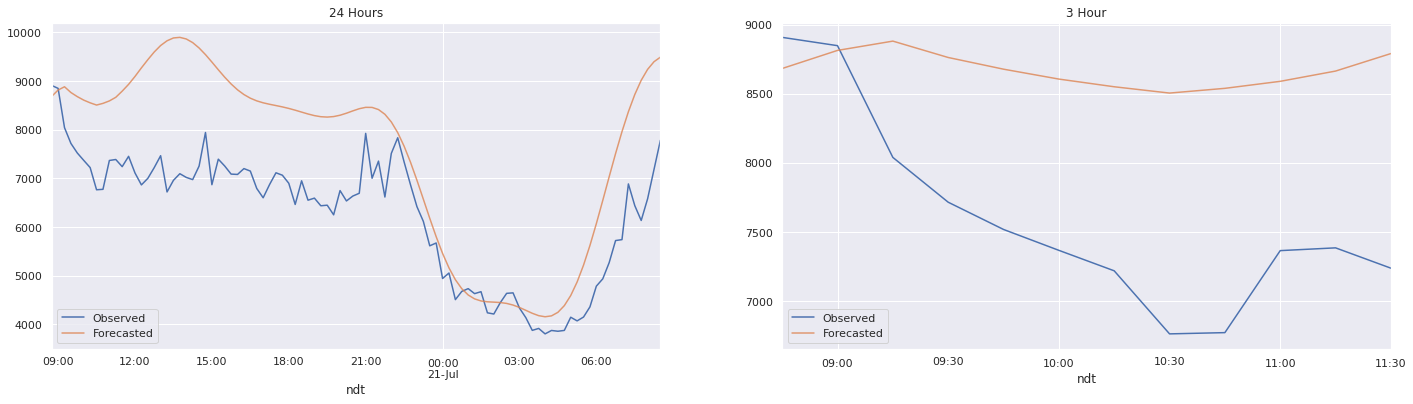

In [76]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(24, 6)
ax[0].set_title("24 Hours")
ax[1].set_title("3 Hour")
showcase_zoom(sea_data[training_split:training_split+day_observations],
              pd.Series(arimax_res.forecast(
                    day_observations,
                    exog=exog_fourier[training_split:training_split+day_observations])),
              ax[0])
showcase_zoom(sea_data[training_split:training_split+forecast_observations],
              pd.Series(arimax_res.forecast(
                    forecast_observations,
                    exog=exog_fourier[training_split:training_split+forecast_observations])),
              ax[1])

In [174]:
arimax_timestamps = []
arimax_forecasts = []
for step in range(training_split, len(anomaly_free_data)):
    clear_output(wait=True)
    print("Step: ", step + 1, "-", len(anomaly_free_data), "; %:", (step + 1)/len(anomaly_free_data), end='\r')
    data_extended = anomaly_free_data[step:step+1]
    arimax_timestamps.append(data_extended.index[0])
    arimax_res = arimax_res.append(data_extended, exog=exog_fourier[step:step+1])
    forecast_exog = exog_fourier[step:step+forecast_observations]
    arimax_forecasts.append(arimax_res.forecast(min(forecast_observations, len(forecast_exog)), exog=forecast_exog).values)
arimax_forecasts = pd.DataFrame(index=arimax_timestamps, data=arimax_forecasts, columns=[f"step_{x}" for x in range(1, forecast_observations+1)])
del arimax_timestamps

Text(0.5, 1.0, '"Live" - 180 Minutes ahead forecasts as new observations are added.')

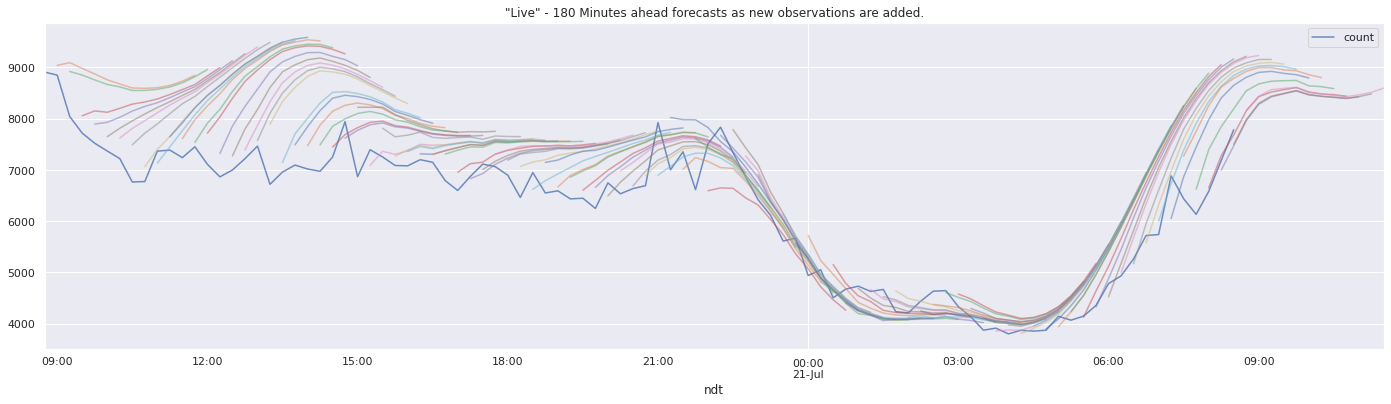

In [79]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(24, 6)
sea_data[training_split:training_split+day_observations].plot(ax=ax, alpha=0.8)

for forecast in arimax_forecasts[:day_observations].iterrows():
    pd.Series(forecast[1].values,
              index = pd.date_range(
                  start=forecast[0] + pd.Timedelta(minutes=15),
                  end=forecast[0] + pd.Timedelta(minutes=forecast_minutes),
                  freq=f"{resample_second_interval}S")
             ).plot(ax=ax, alpha=0.5)
ax.set_title(f"\"Live\" - {forecast_minutes} Minutes ahead forecasts as new observations are added.")

In [175]:
#arimax_forecasts.to_csv('../../data/forecasts/sea_arimax_forecasts_15.csv')

In [29]:
arimax_forecasts = pd.read_csv('../../data/forecasts/sea_arimax_forecasts_15.csv', index_col=0, parse_dates=True)

## TBATS

In [ ]:
#https://github.com/intive-DataScience/tbats

In [81]:
from tbats import TBATS

In [82]:
tbats_mod = TBATS(seasonal_periods=[day_observations], use_box_cox=False)

In [83]:
tbats_res = tbats_mod.fit(sea_data[:training_split])

In [84]:
tbats_res.summary()

'Use Box-Cox: False\nUse trend: False\nUse damped trend: False\nSeasonal periods: [96.]\nSeasonal harmonics [5]\nARMA errors (p, q): (4, 3)\nSmoothing (Alpha): 0.016187\nSeasonal Parameters (Gamma): [-7.67809896e-05 -5.38790761e-06]\nAR coefficients [-5.38790761e-06 -1.79668494e-01  5.49595818e-01  5.54056710e-02]\nMA coefficients [0.93421263 0.84981936 0.19985052]\nSeed vector [8431.90325217 -818.01088072  348.64559005  431.71568834   40.79214266\n  106.4292938  2387.57067779  972.48892575  -80.65686332  353.01707925\n  247.61691437    0.            0.            0.            0.\n    0.            0.            0.        ]\n\nAIC 77240.640544'

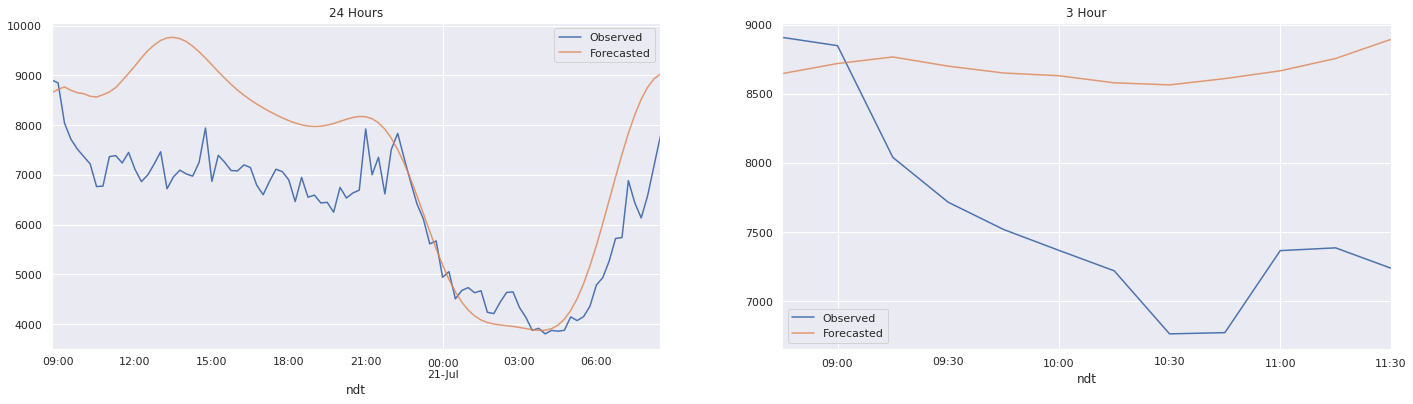

In [85]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(24, 6)
ax[0].set_title("24 Hours")
ax[1].set_title("3 Hour")
showcase_zoom(sea_data[training_split:training_split+day_observations], pd.Series(tbats_res.forecast(day_observations)), ax[0])
showcase_zoom(sea_data[training_split:training_split+forecast_observations], pd.Series(tbats_res.forecast(forecast_observations)), ax[1])

Text(0.5, 1.0, '"Live" - 180 Minutes ahead forecasts as new observations are added.')

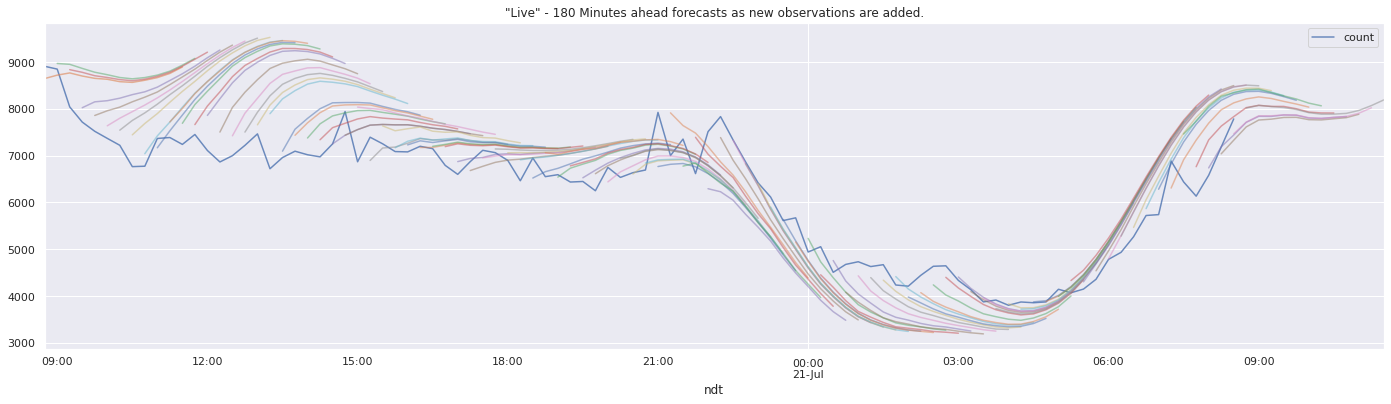

In [86]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(24, 6)
sea_data[training_split:training_split+day_observations].plot(ax=ax, alpha=0.8)

vis_tbats = copy.deepcopy(tbats_res)

pd.Series(vis_tbats.forecast(forecast_observations), index=sea_data.index[training_split:training_split+forecast_observations]).plot(ax=ax, alpha=0.6)
for i in range(1, day_observations+1): # 24 hour ahead
    vis_tbats.fit(sea_data[:training_split+i])
    pd.Series(vis_tbats.forecast(forecast_observations), index=sea_data.index[training_split+i:training_split+i+forecast_observations]).plot(ax=ax, alpha=0.5)
ax.set_title(f"\"Live\" - {forecast_minutes} Minutes ahead forecasts as new observations are added.")

In [88]:
_, tbats_errors = error_n_steps(sea_data, copy.deepcopy(tbats_res), training_split, forecast_observations)

## Evaluation ##

In [89]:
arimax_errors = []
for row in arimax_forecasts.iterrows():
    row_timestamp = row[0]
    row_data = row[1]
    observed_data = sea_data.loc[row_timestamp+pd.Timedelta(minutes=15):row_timestamp+pd.Timedelta(minutes=forecast_minutes)]
    arimax_errors.append((observed_data.values.reshape(1, -1)[0] - row_data[:len(observed_data)].values))
arimax_errors = pd.DataFrame(arimax_errors).fillna(0)

In [90]:
arimax_mse, arimax_rmse = rmse_forecasts(arimax_errors)

In [91]:
naive_mse, naive_rmse = rmse_forecasts(naive_errors)
average_mse, average_rmse = rmse_forecasts(average_errors)
seasonal_naive_mse, seasonal_naive_rmse = rmse_forecasts(seasonal_naive_errors)
ar1_mse, ar1_rmse = rmse_forecasts(ar1_errors)
arimax_mse, arimax_rmse = rmse_forecasts(arimax_errors)
tbats_mse, tbats_rmse = rmse_forecasts(tbats_errors)

In [93]:
forecast_errors = pd.DataFrame()
forecast_errors['naive_mse'] = naive_mse
forecast_errors['naive_rmse'] = naive_rmse
forecast_errors['average_mse'] = average_mse
forecast_errors['average_rmse'] = average_rmse
forecast_errors['seasonal_naive_mse'] = seasonal_naive_mse
forecast_errors['seasonal_naive_rmse'] = seasonal_naive_rmse
forecast_errors['ar1_mse'] = ar1_mse
forecast_errors['ar1_rmse'] = ar1_rmse
forecast_errors['arimax_mse'] = arimax_mse
forecast_errors['arimax_rmse'] = arimax_rmse
forecast_errors['tbats_mse'] = tbats_mse
forecast_errors['tbats_rmse'] = tbats_rmse

Text(0.5, 1.0, 'Average residua distribution')

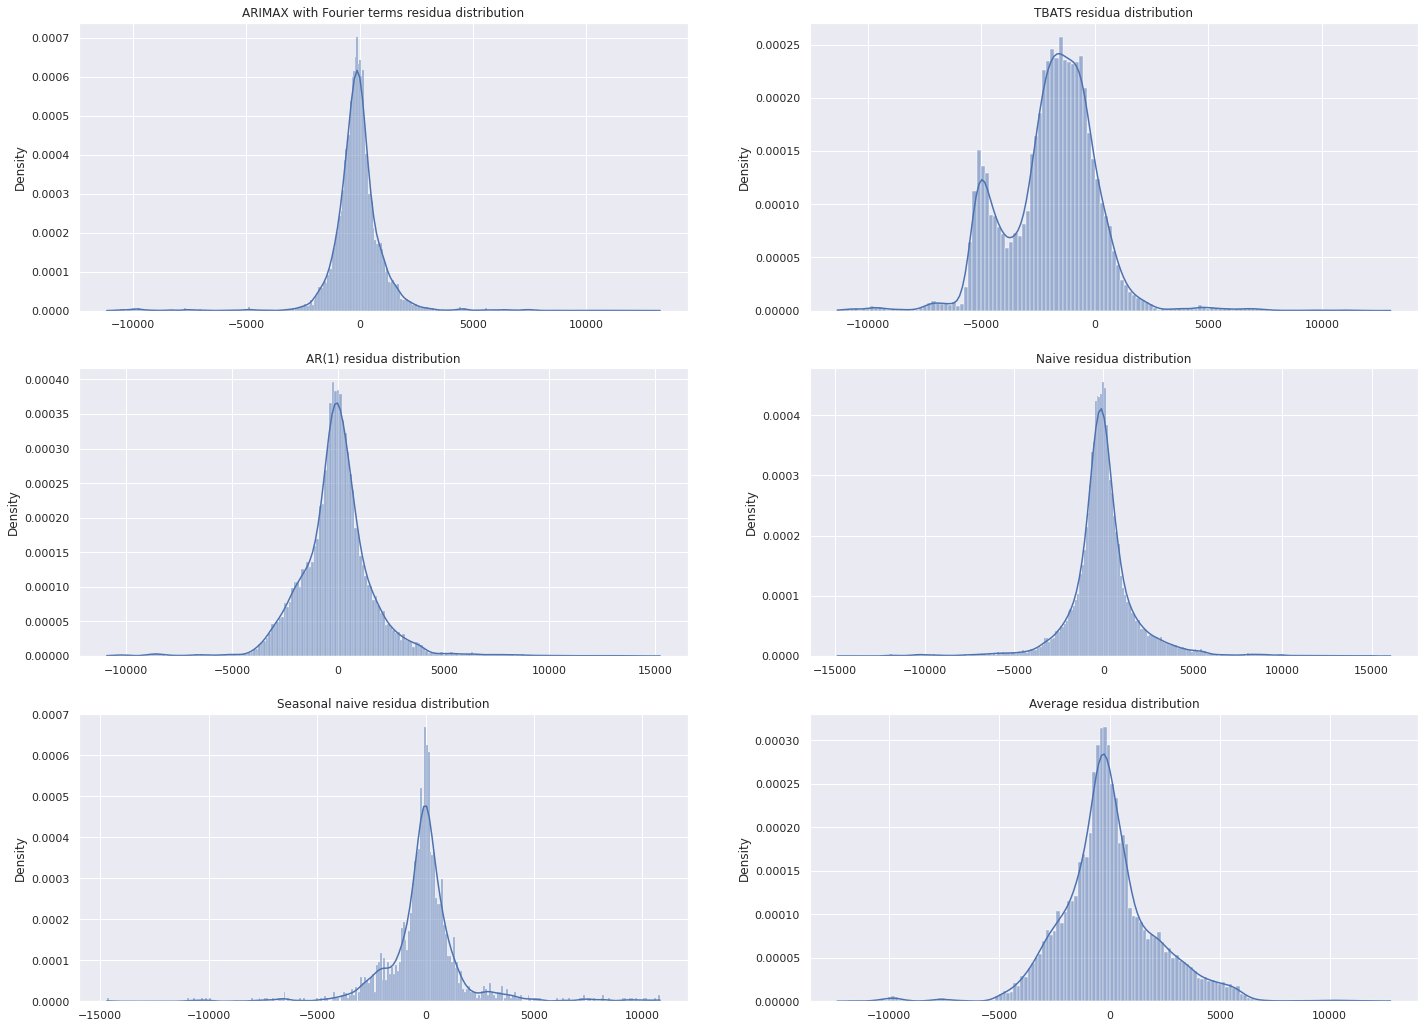

In [94]:
fig, ax = plt.subplots(3, 2)
fig.set_size_inches(24, 18)

arimax_residues = pd.Series(arimax_errors.values.flatten())
tbats_residues = pd.Series(tbats_errors.values.flatten())
ar1_residues = pd.Series(ar1_errors.values.flatten())
naive_residues = pd.Series(naive_errors.values.flatten())
seasonal_naive_residues = pd.Series(seasonal_naive_errors.values.flatten())
average_residues = pd.Series(average_errors.values.flatten())


sns.histplot(arimax_residues, ax=ax[0][0], stat='density', kde=True)
ax[0][0].set_title("ARIMAX with Fourier terms residua distribution")

sns.histplot(tbats_residues, ax=ax[0][1], stat='density', kde=True)
ax[0][1].set_title("TBATS residua distribution")

sns.histplot(ar1_residues, ax=ax[1][0], stat='density', kde=True)
ax[1][0].set_title("AR(1) residua distribution")

sns.histplot(naive_residues, ax=ax[1][1], stat='density', kde=True)
ax[1][1].set_title("Naive residua distribution")

sns.histplot(seasonal_naive_residues, ax=ax[2][0], stat='density', kde=True)
ax[2][0].set_title("Seasonal naive residua distribution")

sns.histplot(average_residues, ax=ax[2][1], stat='density', kde=True)
ax[2][1].set_title("Average residua distribution")

In [95]:
tbats_rmse.index = sea_data[-len(tbats_mse):].index
arimax_rmse.index = sea_data[-len(arimax_mse):].index
naive_rmse.index = sea_data[-len(naive_rmse):].index
average_rmse.index = sea_data[-len(average_rmse):].index
seasonal_naive_rmse.index = sea_data[-len(seasonal_naive_rmse):].index
ar1_rmse.index = sea_data[-len(ar1_rmse):].index

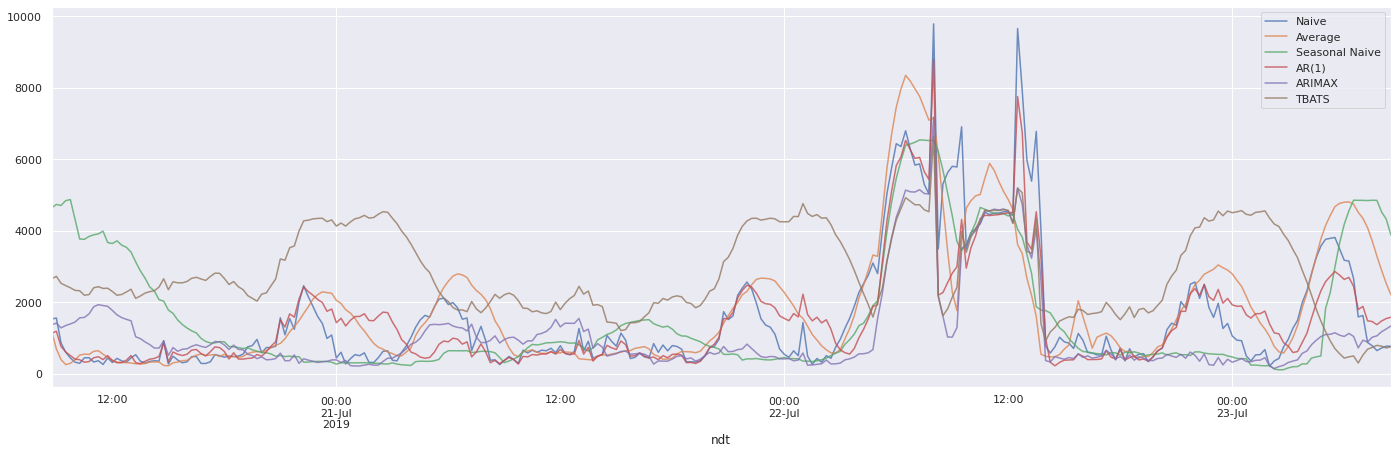

In [96]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(24, 7)

naive_rmse[:day_observations*3].plot(ax=ax, alpha=0.8)
average_rmse[:day_observations*3].plot(ax=ax, alpha=0.8)
seasonal_naive_rmse[:day_observations*3].plot(ax=ax, alpha=0.8)
ar1_rmse[:day_observations*3].plot(ax=ax, alpha=0.8)
arimax_rmse[:day_observations*3].plot(ax=ax, alpha=0.8)
tbats_rmse[:day_observations*3].plot(ax=ax, alpha=0.8)
ax.legend(["Naive", "Average", "Seasonal Naive", "AR(1)", "ARIMAX", "TBATS"])

In [97]:
results = pd.DataFrame(
            data=np.array([
                tbats_rmse.sum(),
                tbats_mse.sum(),
                arimax_rmse.sum(),
                arimax_mse.sum(),
                naive_rmse.sum(),
                naive_mse.sum(),
                seasonal_naive_rmse.sum(),
                seasonal_naive_mse.sum(),
                average_rmse.sum(),
                average_mse.sum(),
                ar1_rmse.sum(),
                ar1_mse.sum(),
            ])
                .reshape(1, -1),
            columns = ['tbats_rmse','tbats_mse',
                       'arimax_rmse','arimax_mse',
                       'naive_rmse', 'naive_mse',
                       'seasonal_naive_rmse', 'seasonal_naive_mse',
                       'average_rmse','average_mse',
                       'ar1_rmse','ar1_mse'])

In [98]:
results

tbats_rmse     tbats_mse   arimax_rmse    arimax_mse    naive_rmse  \
0  3.737407e+06  1.214997e+10  1.365471e+06  2.599048e+09  2.152001e+06   

      naive_mse  seasonal_naive_rmse  seasonal_naive_mse  average_rmse  \
0  5.905347e+09         2.072876e+06        5.965518e+09  2.750939e+06   

    average_mse      ar1_rmse       ar1_mse  
0  7.795591e+09  2.113524e+06  4.887071e+09

In [106]:
for col in results:
    print(col, '{0:.10f}'.format(results[col][0]))

tbats_rmse 3737406.6175112692
tbats_mse 12149974147.6022529602
arimax_rmse 1365471.3779780366
arimax_mse 2599048417.5622091293
naive_rmse 2152001.1382339159
naive_mse 5905347265.5202016830
seasonal_naive_rmse 2072876.4624689464
seasonal_naive_mse 5965517592.5431098938
average_rmse 2750939.0581508814
average_mse 7795591080.3853530884
ar1_rmse 2113524.3451862345
ar1_mse 4887071138.3935756683


In [21]:
len(sea_data[training_split:])

1525

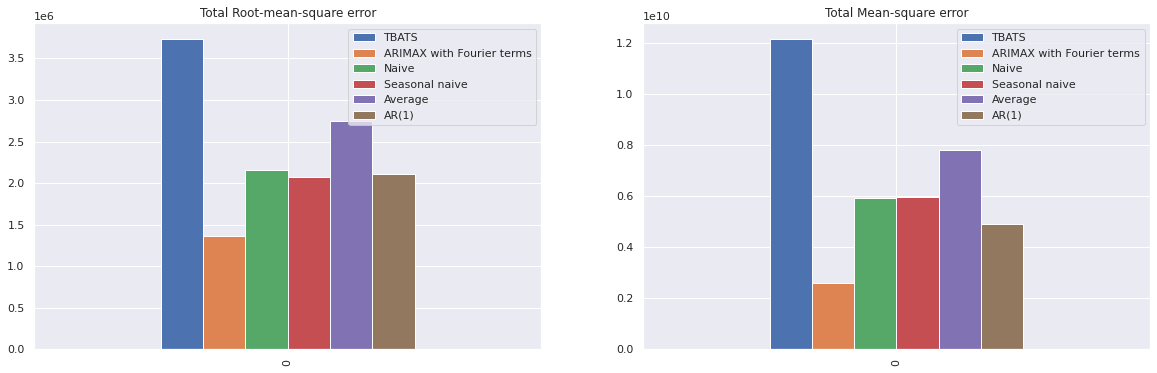

In [99]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(20, 6)

results[['tbats_rmse', 'arimax_rmse', 'naive_rmse', 'seasonal_naive_rmse', 'average_rmse', 'ar1_rmse']].plot(kind='bar', ax=ax[0])
ax[0].set_title("Total Root-mean-square error")
ax[0].legend(["TBATS", "ARIMAX with Fourier terms", "Naive", "Seasonal naive", "Average", 'AR(1)'])


results[['tbats_mse', 'arimax_mse', 'naive_mse', 'seasonal_naive_mse', 'average_mse', 'ar1_mse']].plot(kind='bar', ax=ax[1])
ax[1].set_title("Total Mean-square error")
ax[1].legend(["TBATS", "ARIMAX with Fourier terms", "Naive", "Seasonal naive", "Average", 'AR(1)'])